In [1]:
# Imports
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import astropy
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import (
    CartesianRepresentation,
    get_body_barycentric_posvel,
)

from poliastro.bodies import Earth, Sun

from poliastro.twobody.events import (
    AltitudeCrossEvent,
    LatitudeCrossEvent,
    NodeCrossEvent,
    PenumbraEvent,
    UmbraEvent,
)
from poliastro.twobody.orbit import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray

from poliastro.util import time_range

from poliastro.constants import H0_earth, rho0_earth
from poliastro.core.perturbations import atmospheric_drag_exponential
from poliastro.core.propagation import func_twobody

In [2]:


R = Earth.R.to_value(u.km)

# Parameters of the body
C_D = 2.2  # Dimensionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m**2) / (100 * u.kg)).to_value(
    u.km**2 / u.kg
)  # km^2/kg

# Parameters of the atmosphere
rho0 = rho0_earth.to_value(u.kg / u.km**3)  # kg/km^3
H0 = H0_earth.to_value(u.km)  # km


def f(t0, u_, k):
    du_kep = func_twobody(t0, u_, k)
    ax, ay, az = atmospheric_drag_exponential(
        t0, u_, k, R=R, C_D=C_D, A_over_m=A_over_m, H0=H0, rho0=rho0
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])
    return du_kep + du_ad


In [3]:
tofs = np.arange(0, 2400, 100) << u.s
orbit = Orbit.circular(Earth, 150 * u.km)

# Define a threshold altitude for crossing.
thresh_alt = 50  # in km
altitude_cross_event = AltitudeCrossEvent(thresh_alt, R)  # Set up the event.
events = [altitude_cross_event]

method = CowellPropagator(events=events, f=f)
rr, _ = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=method),
).rv()

print(
    f"The threshold altitude was crossed {altitude_cross_event.last_t} after the orbit's epoch."
)

The threshold altitude was crossed 2063.6700936203247 s after the orbit's epoch.


Text(0.5, 0, 'Time (in s)')

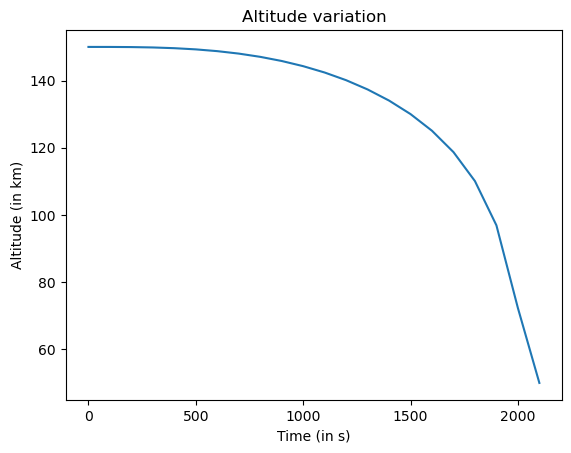

In [4]:
altitudes = np.apply_along_axis(
    norm, 1, (rr << u.km).value
) - Earth.R.to_value(u.km)
plt.plot(tofs[: len(rr)].to_value(u.s), altitudes)
plt.title("Altitude variation")
plt.ylabel("Altitude (in km)")
plt.xlabel("Time (in s)")

In [5]:
orbit = Orbit.from_classical(
    Earth,
    6900 << u.km,
    0.75 << u.one,
    45 << u.deg,
    0 << u.deg,
    0 << u.deg,
    130 << u.deg,
)


In [6]:
thresh_lat = 35 << u.deg
latitude_cross_event = LatitudeCrossEvent(orbit, thresh_lat, terminal=True)
events = [latitude_cross_event]

tofs = np.arange(0, 20 * orbit.period.to_value(u.s), 150) << u.s
method = CowellPropagator(events=events)
rr, _ = orbit.to_ephem(EpochsArray(orbit.epoch + tofs, method=method)).rv()
print(
    f"The threshold latitude was crossed {latitude_cross_event.last_t} s after the orbit's epoch"
)

The threshold latitude was crossed 5225.7148541757515 s s after the orbit's epoch


Text(0.5, 0, 'Time (in days)')

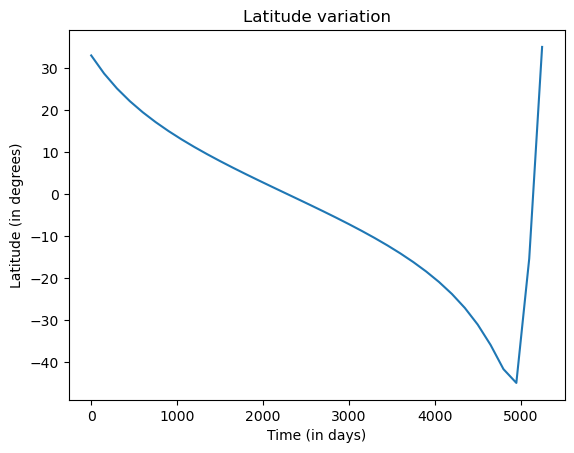

In [7]:
from poliastro.core.spheroid_location import cartesian_to_ellipsoidal

latitudes = []
for r in rr:
    position_on_body = (r / norm(r)) * Earth.R
    lat, _, _ = cartesian_to_ellipsoidal(
        Earth.R, Earth.R_polar, *position_on_body
    )
    latitudes.append(np.rad2deg(lat))
plt.plot(tofs[: len(rr)].to_value(u.s), latitudes)
plt.title("Latitude variation")
plt.ylabel("Latitude (in degrees)")
plt.xlabel("Time (in days)")

In [ ]:
from poliastro.earth import EarthSatellite
from poliastro.earth.plotting import GroundtrackPlotter
from poliastro.plotting import StaticOrbitPlotter

es = EarthSatellite(orbit, None)

# Show the groundtrack plot from
t_span = time_range(orbit.epoch, end=orbit.epoch + latitude_cross_event.last_t)

# Generate ground track plotting instance.
gp = GroundtrackPlotter()
gp.update_layout(title="Latitude Crossing")

# Plot the above-defined earth satellite.
gp.plot(
    es,
    t_span,
    label="Orbit",
    color="red",
    marker={
        "size": 10,
        "symbol": "triangle-right",
        "line": {"width": 1, "color": "black"},
    },
)